In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from collections import Counter

In [3]:
df = pd.read_csv("/kaggle/input/lung-cancer-mortality-datasets-v2/lung_cancer_mortality_data_test_v2.csv")

In [4]:
df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,beginning_of_treatment_date,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Female,Slovakia,2016-04-07,Stage IV,2016-04-09,No,Former Smoker,21.2,191,0,0,0,0,Surgery,2017-02-10,0
1,2,50.0,Male,Slovenia,2023-04-22,Stage III,2023-05-05,Yes,Current Smoker,36.4,258,1,0,0,0,Chemotherapy,2024-08-23,0
2,3,65.0,Male,Italy,2023-04-07,Stage II,2023-04-12,Yes,Former Smoker,18.9,174,1,0,1,0,Chemotherapy,2025-03-24,1
3,4,51.0,Male,Latvia,2016-02-07,Stage I,2016-03-08,No,Passive Smoker,38.8,279,1,0,0,0,Combined,2017-03-01,0
4,5,37.0,Female,Spain,2023-12-01,Stage II,2023-12-04,Yes,Former Smoker,37.7,273,0,0,0,0,Combined,2025-07-16,0


In [5]:
df.shape

(1000, 18)

# Looking out for NULL values

In [6]:
df.isna().sum()

id                             0
age                            0
gender                         0
country                        0
diagnosis_date                 0
cancer_stage                   0
beginning_of_treatment_date    0
family_history                 0
smoking_status                 0
bmi                            0
cholesterol_level              0
hypertension                   0
asthma                         0
cirrhosis                      0
other_cancer                   0
treatment_type                 0
end_treatment_date             0
survived                       0
dtype: int64

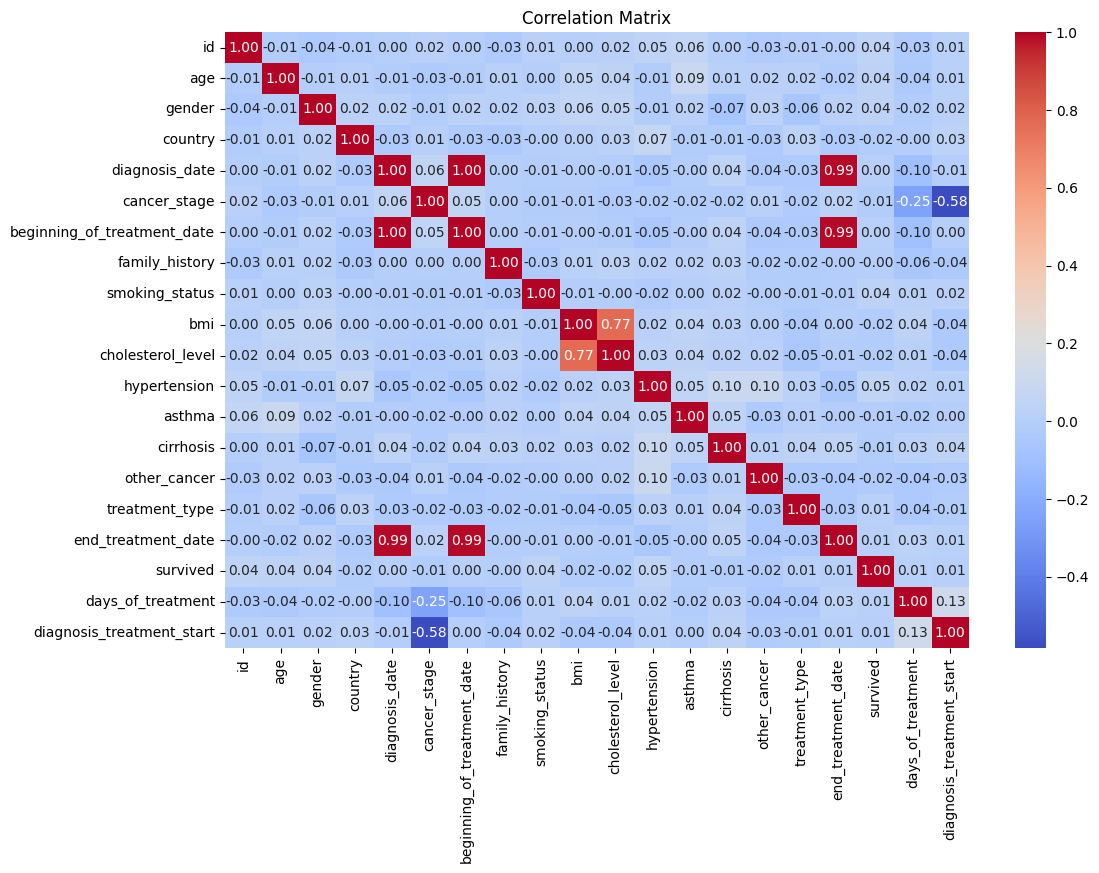

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert dates to datetime format if needed
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'])
df['beginning_of_treatment_date'] = pd.to_datetime(df['beginning_of_treatment_date'])
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'])

# Create the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [7]:
def datediff(x, y):
    date_x = datetime.strptime(x, "%Y-%m-%d")
    date_y = datetime.strptime(y, "%Y-%m-%d")
    diff = date_y - date_x
    
    return diff.days

# Calculating the total number of days for tratment despite the outcome

In [8]:
df["days_of_treatment"] = 0

for i in range(df.shape[0]):
    df.iloc[i, -1] = datediff(df.iloc[i, 4], df.iloc[i, -3])

In [9]:
df["diagnosis_treatment_start"] = 0

for i in range(df.shape[0]):
    df.iloc[i, -1] = datediff(df.iloc[i, 4], df.iloc[i, 6])

# Ratio of lethal and successful outcome

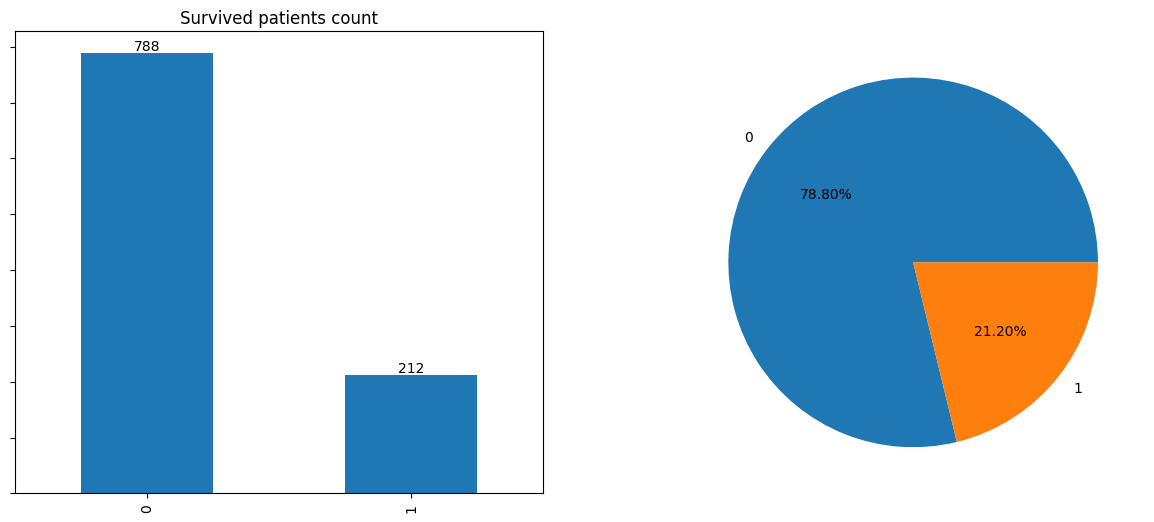

In [10]:
count = df["survived"].value_counts()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
count.plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Survived patients count")
count.plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()

# Average time to start treatment

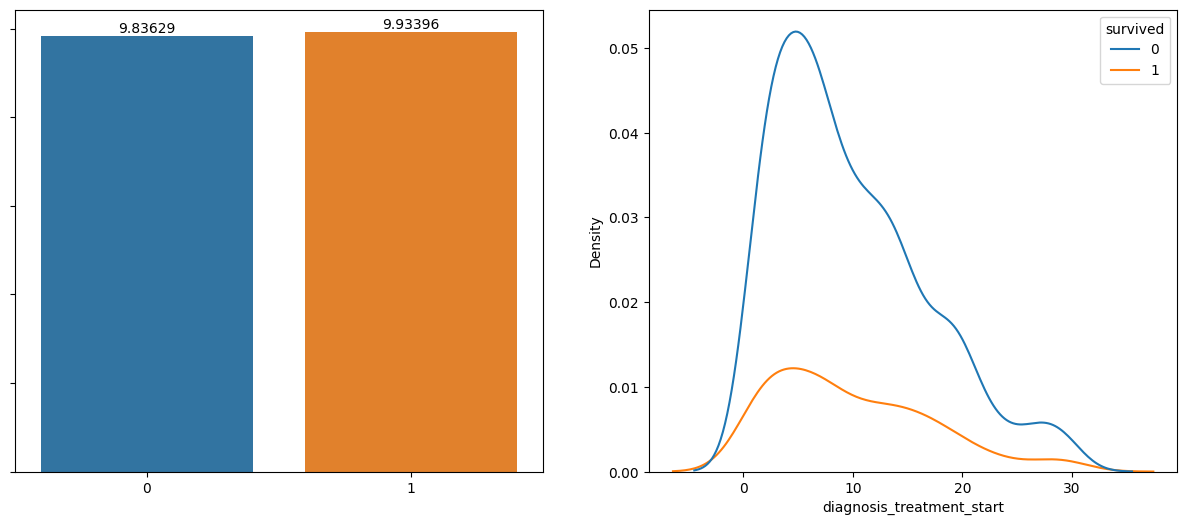

In [11]:
grouped = df.groupby("survived")
mean = grouped["diagnosis_treatment_start"].mean()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x=mean.index, y=mean, ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")

sns.kdeplot(df, x="diagnosis_treatment_start", hue="survived", ax=axes[1])

plt.show()

# Top countries with highest average time to start treatment and lowest average time to start treatment

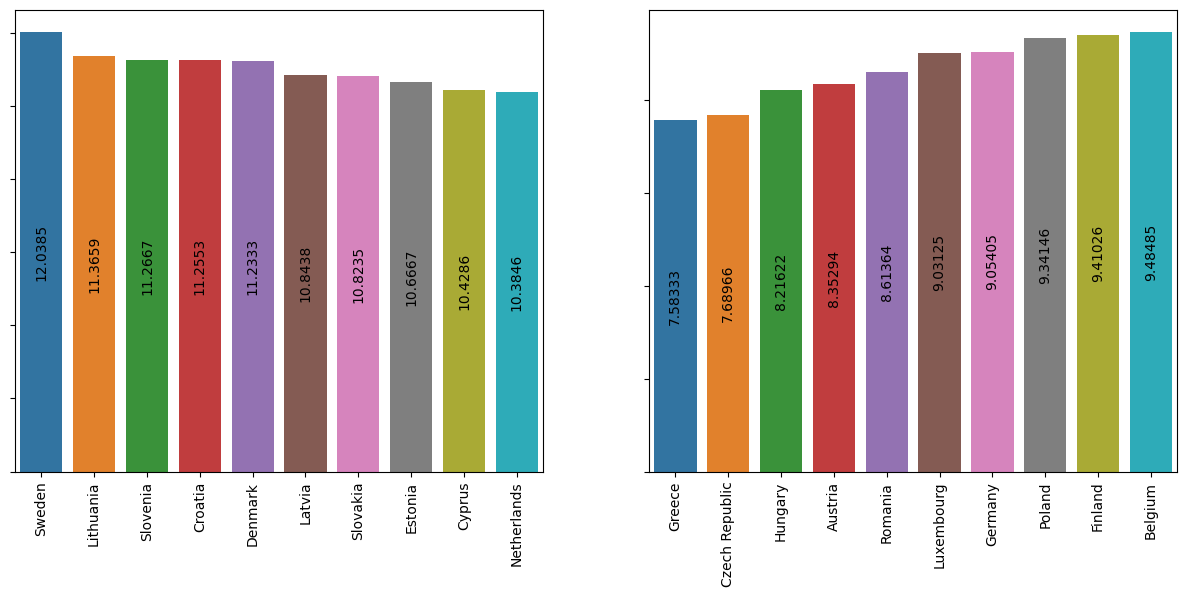

In [12]:
grouped = df.groupby("country")
mean = pd.DataFrame(grouped["diagnosis_treatment_start"].mean())
mean = mean.sort_values("diagnosis_treatment_start", ascending=False)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x=mean.index[:10], y=mean.iloc[:10, 0], ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container, rotation=90, label_type="center")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")


mean = mean.sort_values("diagnosis_treatment_start", ascending=True)
sns.barplot(x=mean.index[:10], y=mean.iloc[:10, 0], ax=axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container, rotation=90, label_type="center")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_yticklabels(())
axes[1].set_ylabel("")
axes[1].set_xlabel("")


plt.show()

# Average time of treatment in days and days distribution for each outcome

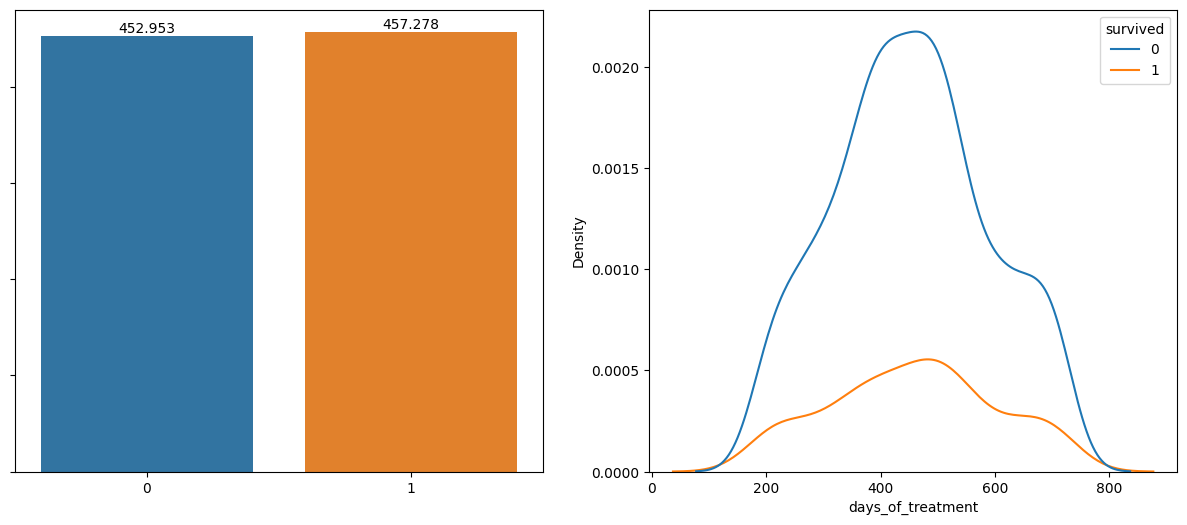

In [13]:
grouped = df.groupby("survived")
mean = grouped["days_of_treatment"].mean()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x=mean.index, y=mean, ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")

sns.kdeplot(df, x="days_of_treatment", hue="survived", ax=axes[1])

plt.show()

# Average age for both outcomes and age distribution through density curve

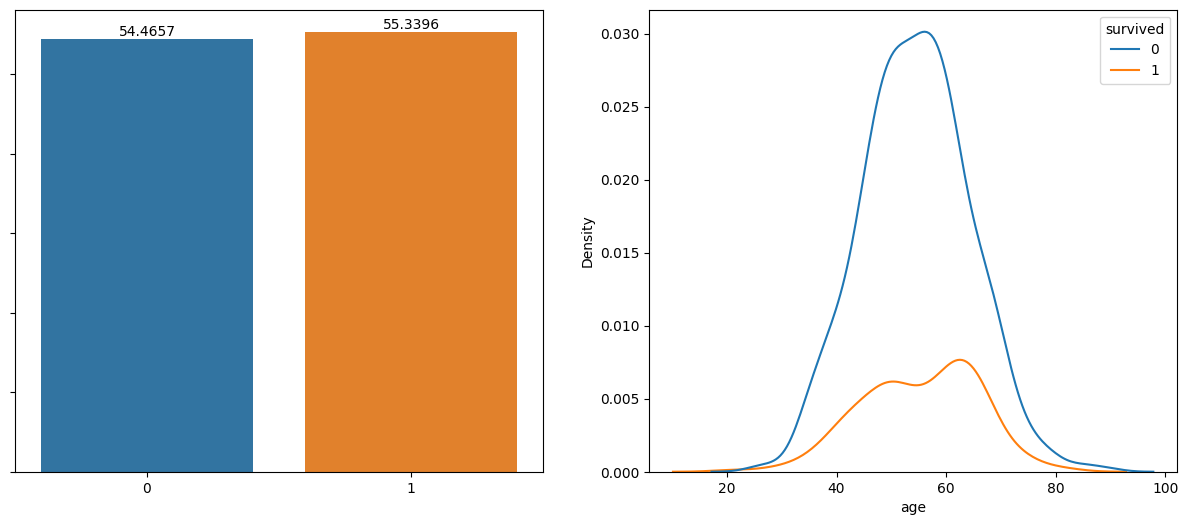

In [14]:
grouped = df.groupby("survived")
mean = grouped["age"].mean()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x=mean.index, y=mean, ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")

sns.kdeplot(df, x="age", hue="survived", ax=axes[1])

plt.show()

In [15]:
survived_df = df[df["survived"] == 1].copy()
dead_df = df[df["survived"] == 0].copy()

# Countires count for each outcome

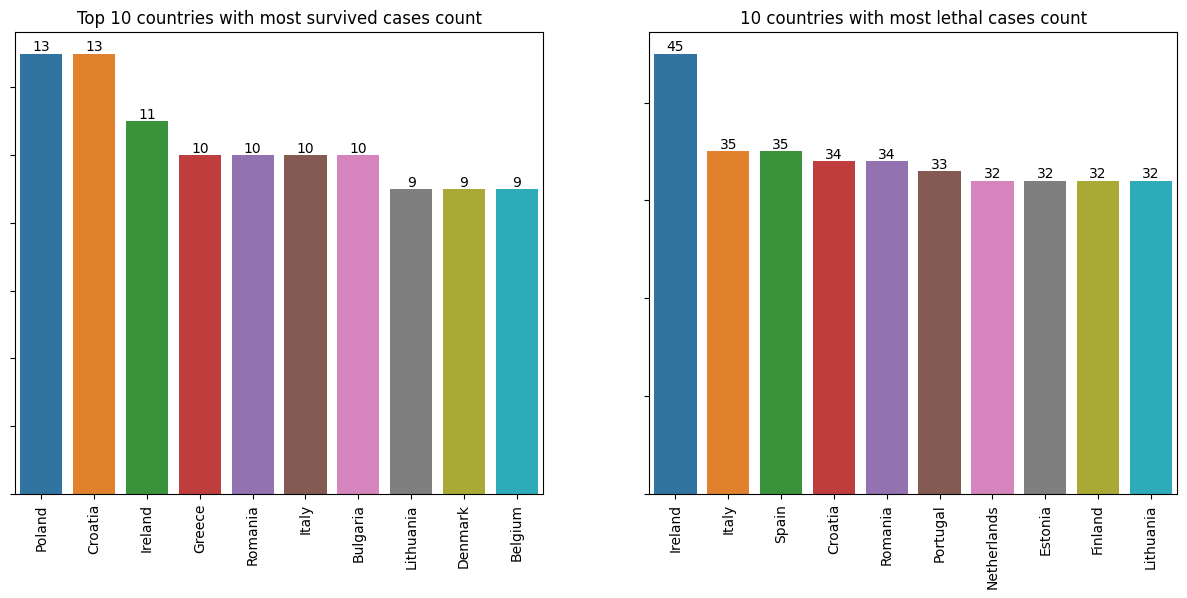

In [16]:
survived_count = pd.DataFrame(survived_df["country"].value_counts()).sort_values("count", ascending=False)
dead_count = pd.DataFrame(dead_df["country"].value_counts()).sort_values("count", ascending=False)

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

sns.barplot(x=survived_count.index[:10], y=survived_count.iloc[:10, 0], ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Top 10 countries with most survived cases count")
sns.barplot(x=dead_count.index[:10], y=dead_count.iloc[:10, 0], ax=axes[1])

for container in axes[1].containers:
    axes[1].bar_label(container)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_yticklabels(())
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_title("10 countries with most lethal cases count")

plt.show()

# Countries count with highest number of the following smoking statuses

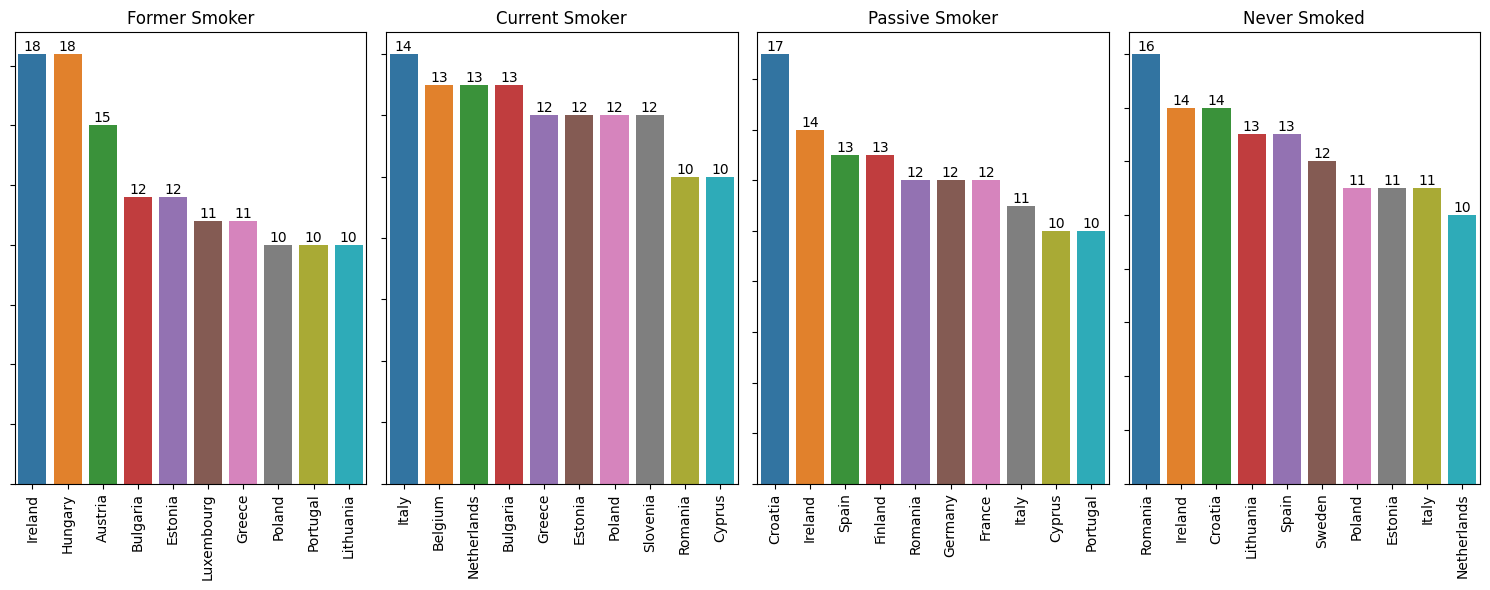

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
for i, j in enumerate(df["smoking_status"].unique()):
    temp_df = df[df["smoking_status"] == j]
    count = pd.DataFrame(temp_df["country"].value_counts()).sort_values("count", ascending=False)
    sns.barplot(x=count.index[:10], y=count.iloc[:10, 0], ax=axes[i])
    for container in axes[i].containers:
        axes[i].bar_label(container)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    axes[i].set_yticklabels(())
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].set_title(j)
plt.tight_layout()
plt.show()

# Count of smoking status and its influence on lung cancer occurence

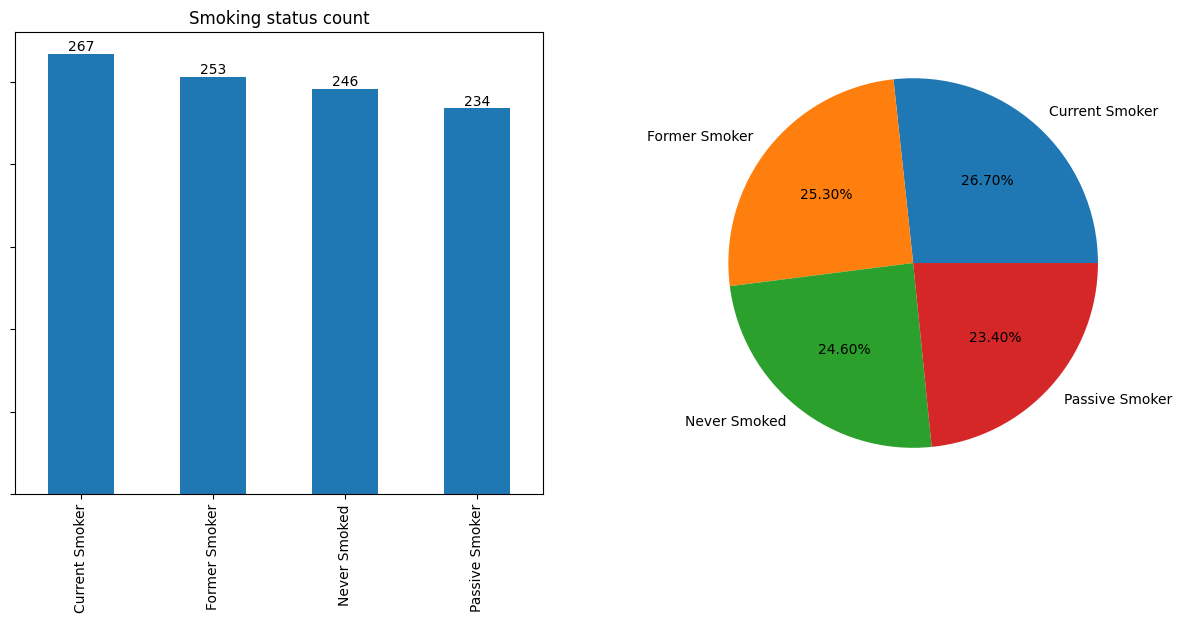

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
df["smoking_status"].value_counts().plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Smoking status count")
df["smoking_status"].value_counts().plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()

# Influence of smoking status on cancer survival

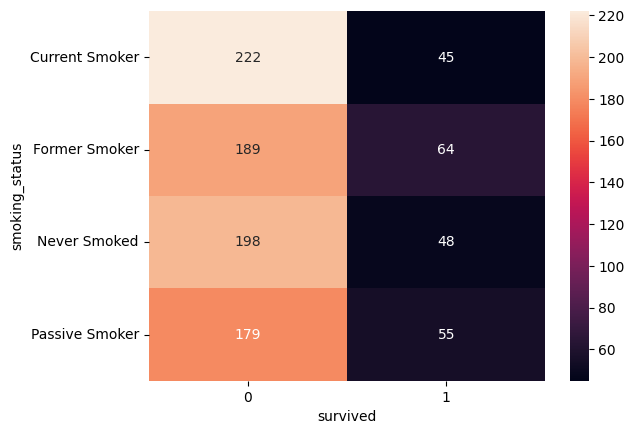

In [19]:
cross = pd.crosstab(df["smoking_status"], df["survived"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

# 10 countries with highest BMI levels and cholesterol levels

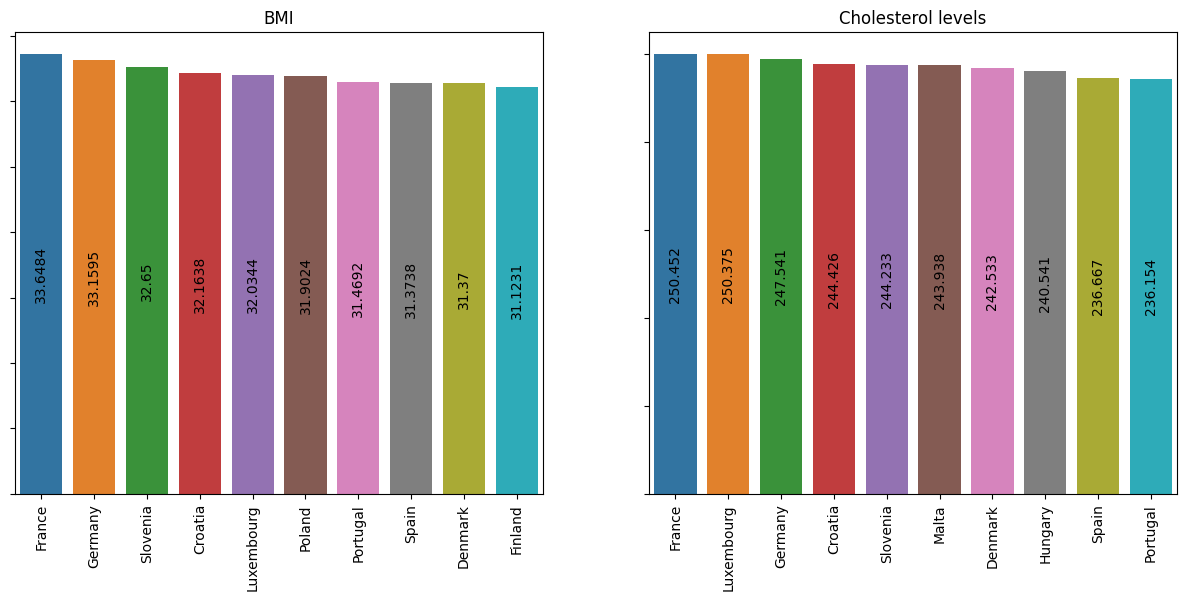

In [20]:
grouped = df.groupby("country")
bmi = pd.DataFrame(grouped["bmi"].mean()).sort_values("bmi", ascending=False)
chol = pd.DataFrame(grouped["cholesterol_level"].mean()).sort_values("cholesterol_level", ascending=False)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
i = 0
sns.barplot(x=bmi.index[:10], y=bmi.iloc[:10, 0], ax=axes[i])
for container in axes[i].containers:
    axes[i].bar_label(container, rotation=90, label_type="center")
axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
axes[i].set_yticklabels(())
axes[i].set_ylabel("")
axes[i].set_xlabel("")
axes[i].set_title("BMI")
i += 1
sns.barplot(x=chol.index[:10], y=chol.iloc[:10, 0], ax=axes[i])
for container in axes[i].containers:
    axes[i].bar_label(container, rotation=90, label_type="center")
axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
axes[i].set_yticklabels(())
axes[i].set_ylabel("")
axes[i].set_xlabel("")
axes[i].set_title("Cholesterol levels")
plt.show()

# Data distribution of BMI and cholesterol levels for cases with lethal and non-lethal outcomes

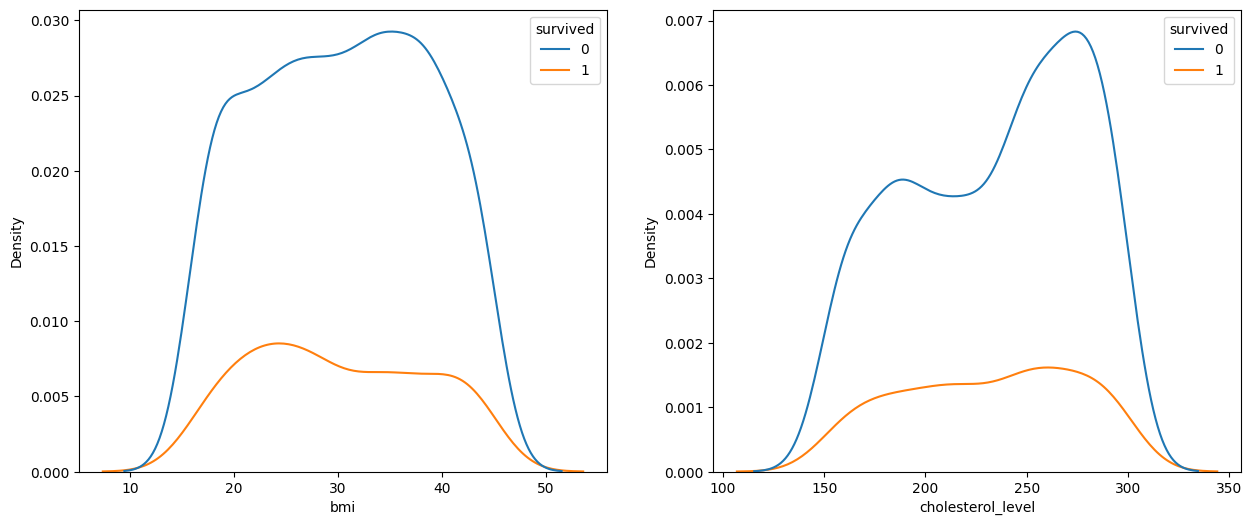

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

sns.kdeplot(df, x="bmi", hue="survived", ax=axes[0])
sns.kdeplot(df, x="cholesterol_level", hue="survived", ax=axes[1])
plt.show()

# Count of gender with lung cancer cases

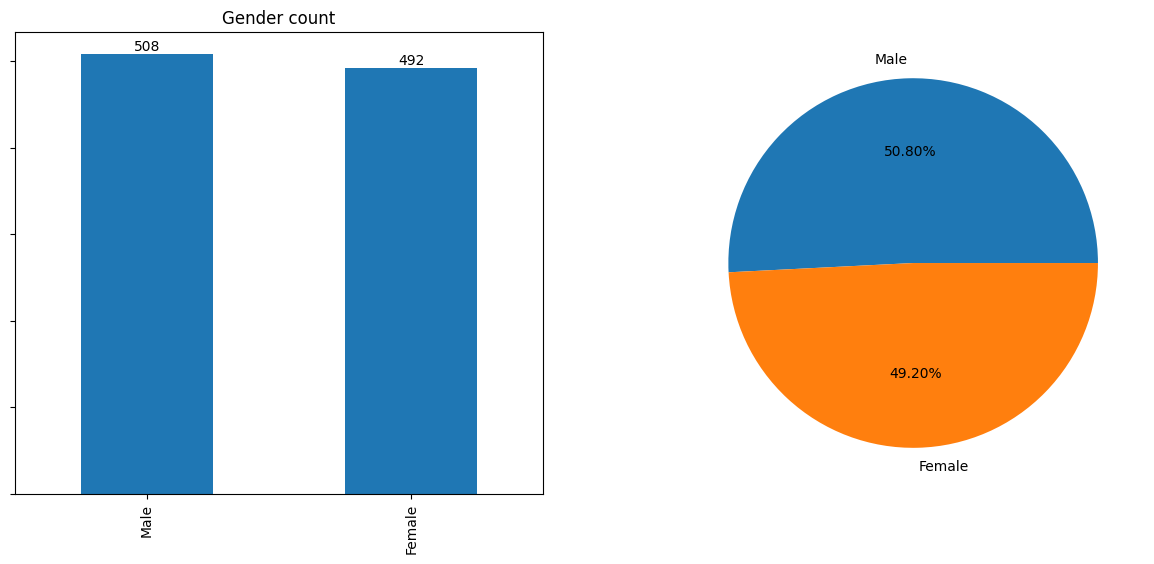

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
df["gender"].value_counts().plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Gender count")
df["gender"].value_counts().plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()

# Influence of gender on lung cancer

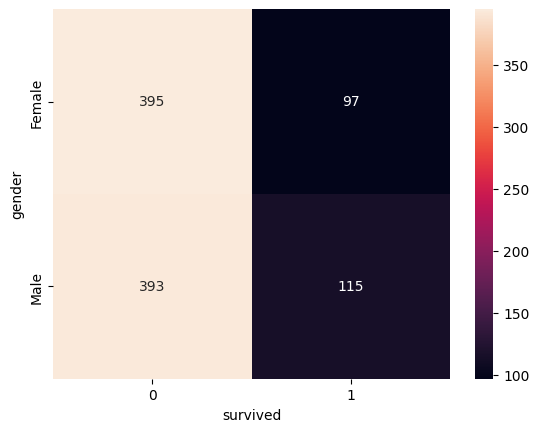

In [23]:
cross = pd.crosstab(df["gender"], df["survived"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

# Average age in both genders to have lung cancer

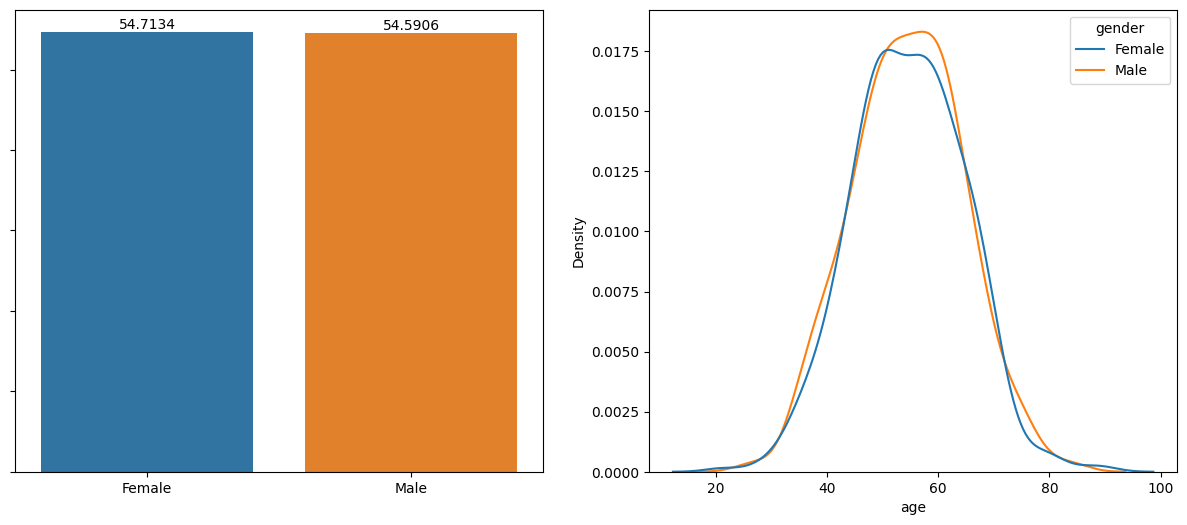

In [24]:
grouped = df.groupby("gender")
mean = grouped["age"].mean()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x=mean.index, y=mean, ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")

sns.kdeplot(df, x="age", hue="gender", ax=axes[1])

plt.show()

# Which gender has tendencies for various smoking statuses

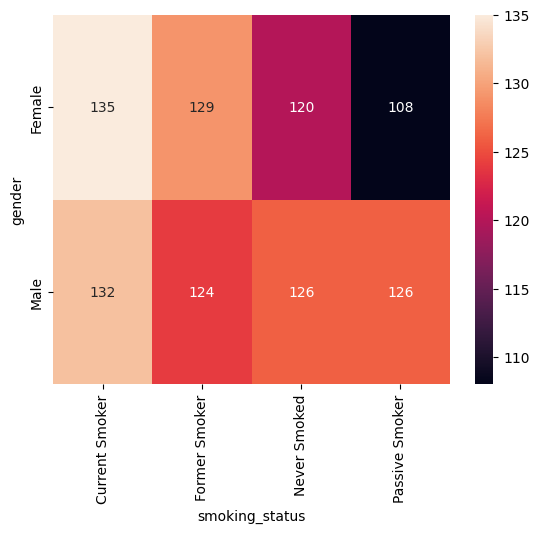

In [25]:
cross = pd.crosstab(df["gender"], df["smoking_status"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

# Influence of other diagnoses on the outcome of treatment

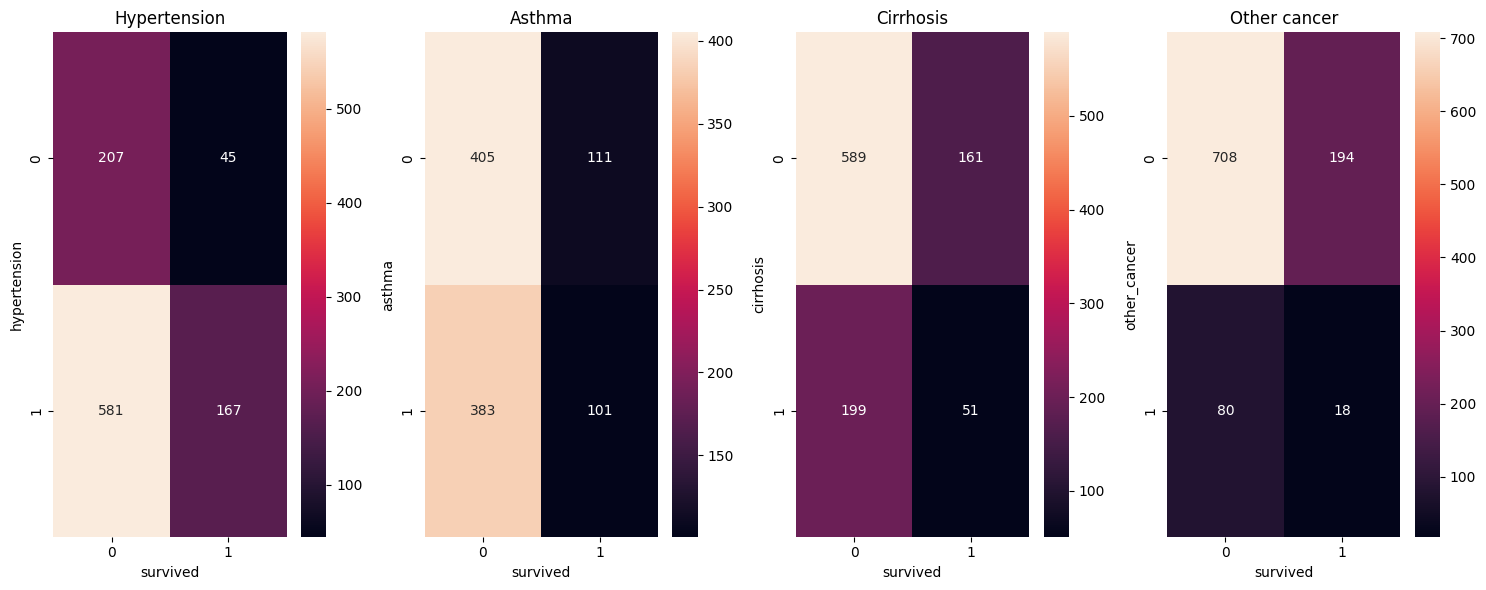

In [26]:
diseases = ["hypertension", "asthma", "cirrhosis", "other_cancer"]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
for i, j in enumerate(diseases):
    cross = pd.crosstab(df[j], df["survived"])
    sns.heatmap(cross, annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(j.replace('_', ' ').capitalize())
plt.tight_layout()
plt.show()

# Treatment approaches tendencies

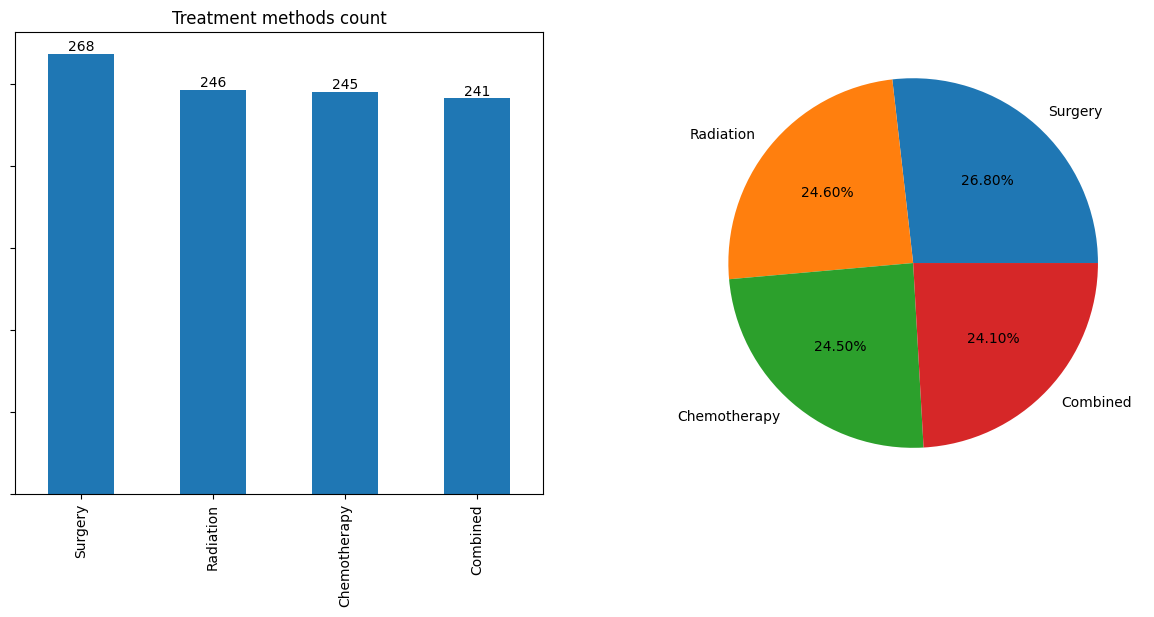

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
df["treatment_type"].value_counts().plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Treatment methods count")
df["treatment_type"].value_counts().plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()

# Influence of treatment type on the outcome

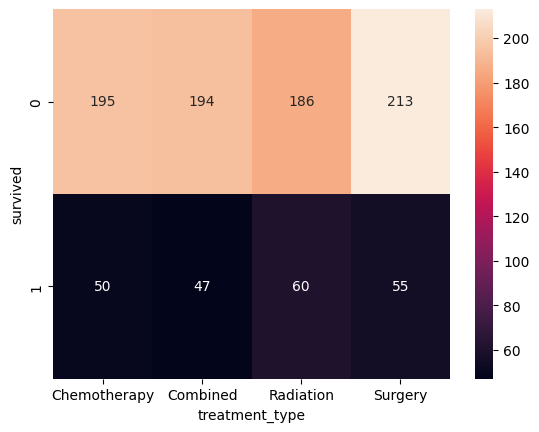

In [28]:
cross = pd.crosstab(df["survived"], df["treatment_type"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

# Cases of lung cancer in family history influence on lung cancer occurence

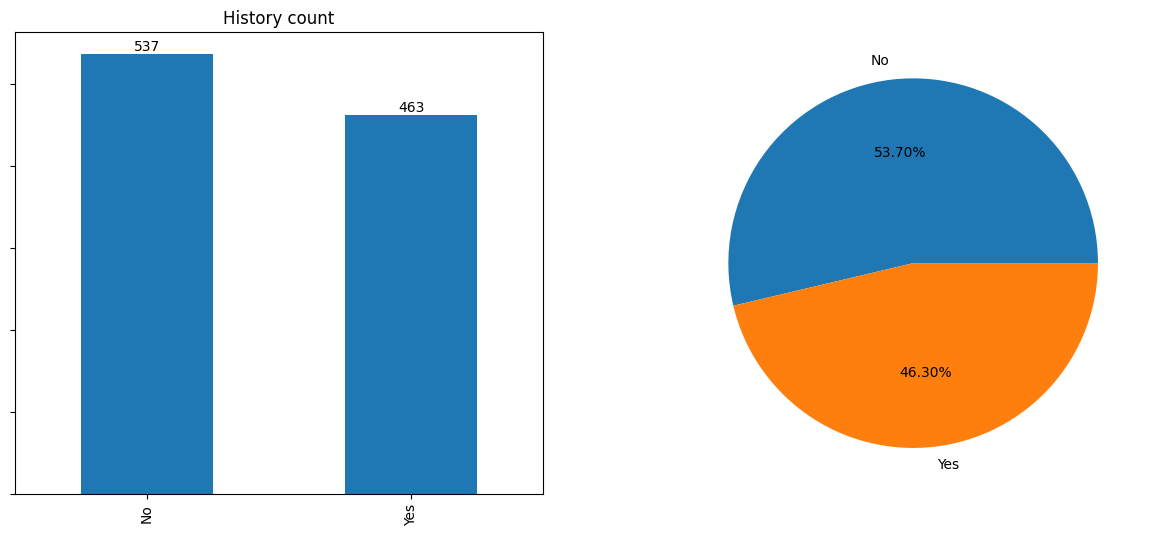

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
df["family_history"].value_counts().plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("History count")
df["family_history"].value_counts().plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()

# Influence of family history on survival

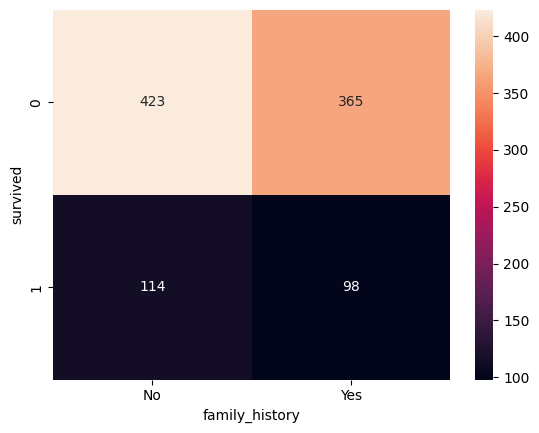

In [30]:
cross = pd.crosstab(df["survived"], df["family_history"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

# Encoding categorical variables

In [31]:
categoricals = ["gender", "country", "cancer_stage", "family_history", "smoking_status", "treatment_type"]

le = LabelEncoder()
for i in categoricals:
    df[i] = le.fit_transform(df[i].values)

# Selecting features for training

In [32]:
x = df.drop(["id", "diagnosis_date", "end_treatment_date", "survived", "beginning_of_treatment_date"], axis=1).values
y = df.loc[:, "survived"].values

# Scaling values

In [33]:
scaler = MinMaxScaler()

x = scaler.fit_transform(x)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

# Applying SMOTE to deal with class imbalance

In [35]:
smote = SMOTE()
print("Before: ", Counter(y_train))
x_train, y_train = smote.fit_resample(x_train, y_train)
print("After: ", Counter(y_train))

Before:  Counter({0: 630, 1: 170})
After:  Counter({0: 630, 1: 630})


In [36]:
def training(model):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    proba = model.predict_proba(x_test)
    score = accuracy_score(pred, y_test)
    report = classification_report(pred, y_test)
    cm = confusion_matrix(pred, y_test)
    
    return score*100, report, cm, pred, proba

# Classic ML models

In [38]:
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
lgr = LogisticRegression()

models = [rfc,abc,lgr]

names = ["Random Forest", "Ada Boost", "Logistic Regression"]


In [39]:
scores, reports, cms, preds, probas = [], dict(), dict(), dict(), dict()

for i, j in zip(models, names):
    score, report, cm, pred, proba = training(i)
    scores += [score]
    reports[j] = report
    cms[j] = cm
    preds[j] = pred
    probas[j] = proba

# Models evaluation score rated

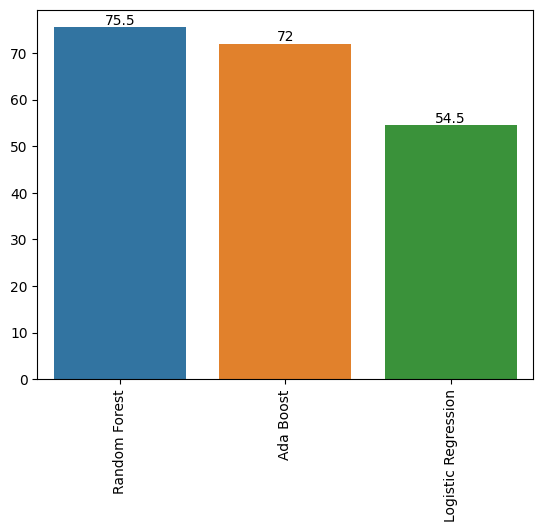

In [40]:
dd = pd.DataFrame({"scores": scores}, index=names).sort_values("scores", ascending=False)
dd["scores"] = round(dd["scores"], 2)
fig, axes = plt.subplots()
sns.barplot(x=dd.index, y=dd.iloc[:, 0], ax=axes)
for container in axes.containers:
    axes.bar_label(container)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.get_yticklabels(())
axes.set_xlabel("")
axes.set_ylabel("")

plt.show()

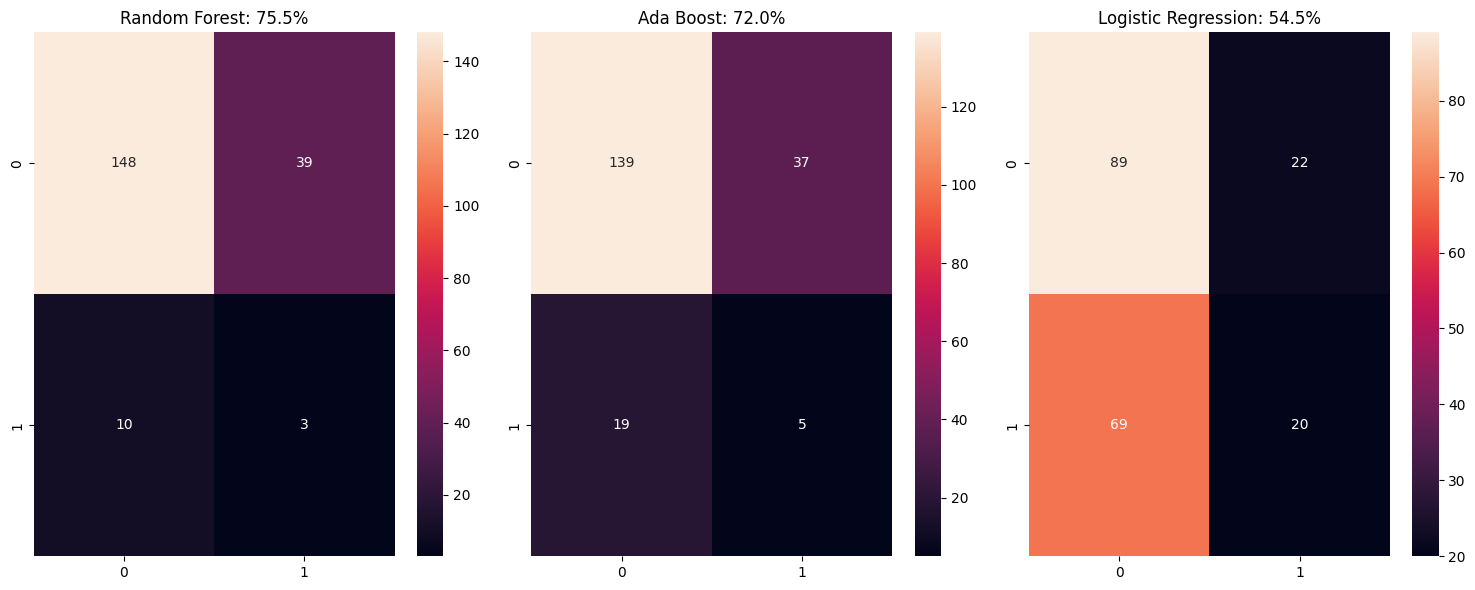

In [41]:
index = 0
for i in range(1):
    fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
    for j in range(3):
        sns.heatmap(cms[dd.index[index]], annot=True, fmt='d', ax=axes[j])
        axes[j].set_title("{}: {}%".format(dd.index[index], dd.iloc[index, 0]))
        index += 1
    plt.tight_layout()
    plt.show()

In [42]:
for i in dd.index:
    print(i)
    print(reports[i])
    print("\n\n")

Random Forest
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       187
           1       0.07      0.23      0.11        13

    accuracy                           0.76       200
   macro avg       0.50      0.51      0.48       200
weighted avg       0.88      0.76      0.81       200




Ada Boost
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       176
           1       0.12      0.21      0.15        24

    accuracy                           0.72       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.79      0.72      0.75       200




Logistic Regression
              precision    recall  f1-score   support

           0       0.56      0.80      0.66       111
           1       0.48      0.22      0.31        89

    accuracy                           0.55       200
   macro avg       0.52      0.51      0.48       200
weighted avg       0.52 

In [43]:
from sklearn.model_selection import GridSearchCV

def training_with_grid_search(model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    pred = best_model.predict(x_test)
    proba = best_model.predict_proba(x_test)
    score = accuracy_score(pred, y_test)
    report = classification_report(pred, y_test)
    cm = confusion_matrix(pred, y_test)
    
    return score*100, report, cm, pred, proba, grid_search.best_params_

# Define parameter grids for each model
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Ada Boost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2']
    }
}

scores, reports, cms, preds, probas, best_params = [], dict(), dict(), dict(), dict(), dict()

for model, name in zip(models, names):
    score, report, cm, pred, proba, best_param = training_with_grid_search(model, param_grids[name])
    scores.append(score)
    reports[name] = report
    cms[name] = cm
    preds[name] = pred
    probas[name] = proba
    best_params[name] = best_param

# Display the best parameters
for name, params in best_params.items():
    print(f"Best parameters for {name}: {params}")


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for Ada Boost: {'learning_rate': 1.0, 'n_estimators': 200}
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}


In [44]:
for name, score in zip(names, scores):
    print(f"Accuracy of {name}: {score:.2f}%")

Accuracy of Random Forest: 73.50%
Accuracy of Ada Boost: 71.00%
Accuracy of Logistic Regression: 54.50%


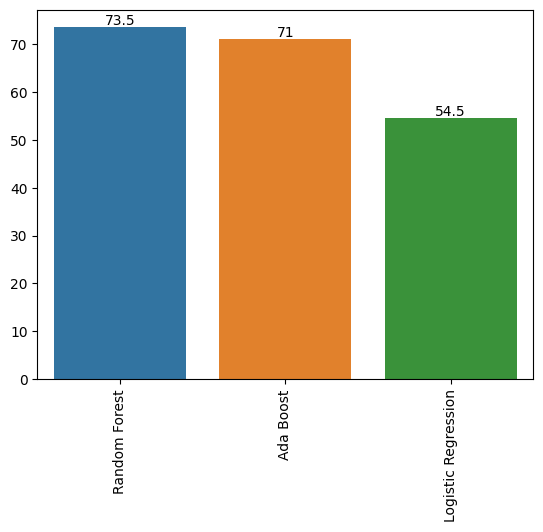

In [45]:
dd = pd.DataFrame({"scores": scores}, index=names).sort_values("scores", ascending=False)
dd["scores"] = round(dd["scores"], 2)
fig, axes = plt.subplots()
sns.barplot(x=dd.index, y=dd.iloc[:, 0], ax=axes)
for container in axes.containers:
    axes.bar_label(container)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.get_yticklabels(())
axes.set_xlabel("")
axes.set_ylabel("")

plt.show()


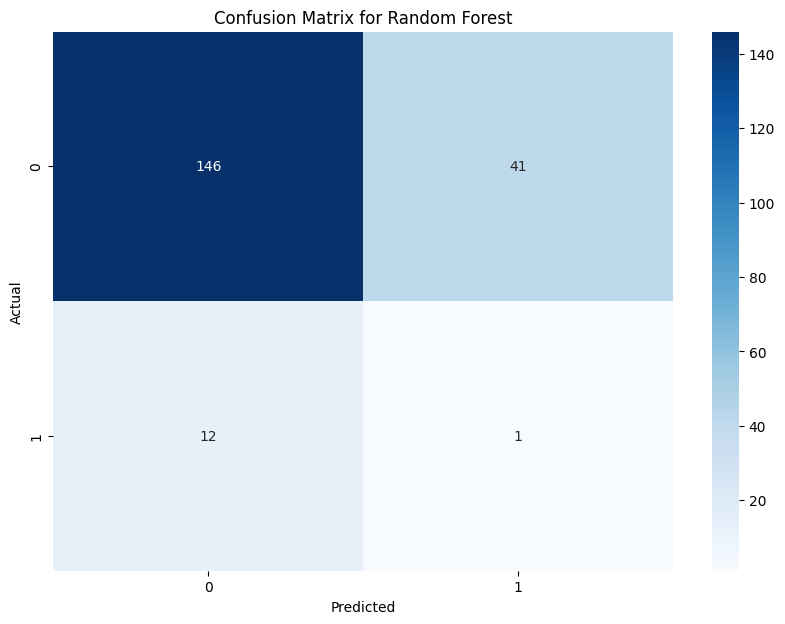

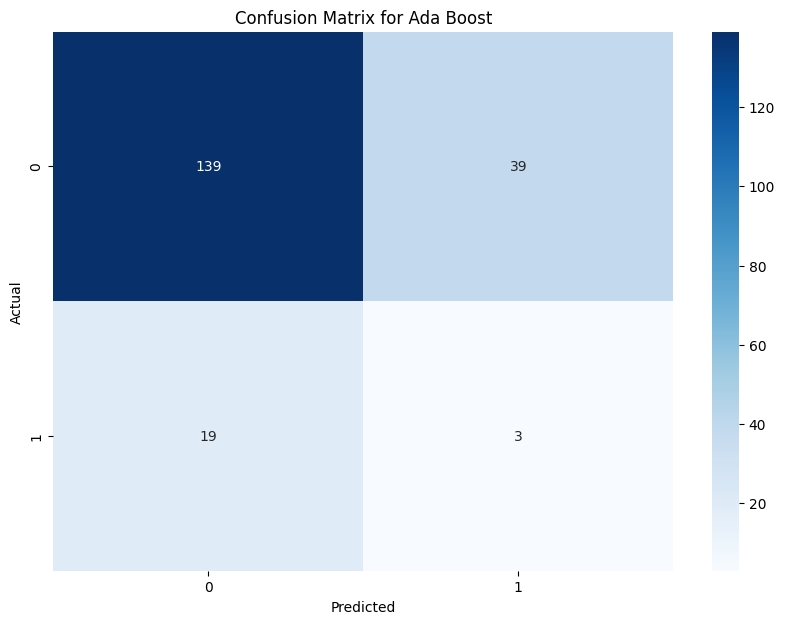

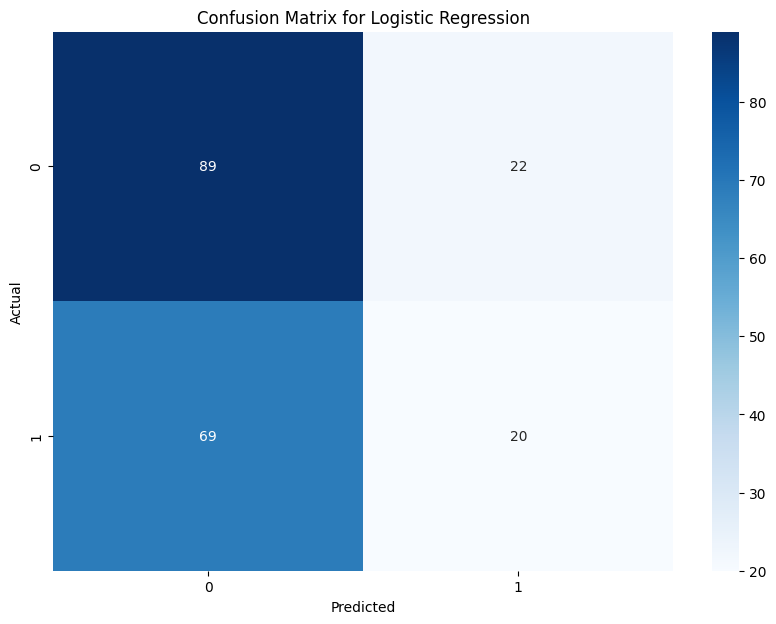

In [46]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Assuming `cms` is a dictionary where keys are model names and values are confusion matrices
for name, cm in cms.items():
    plot_confusion_matrix(cm, name)